In [375]:
##################################### HELPER FUNCTIONS AND CONFIGURATIONS #########################################

import seaborn as sns # for data visualization
from matplotlib.collections import PathCollection
import os
import pprint
import random
import statistics
import scipy.stats
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import json
import pandas as pd
import glob
%matplotlib inline

pp       =  pprint.PrettyPrinter(compact=True)

LOGFILES =  glob.glob('../logs/cleps-logs/17022022/*' )

print(LOGFILES)

#=== line colors and styles

linestyles = {
    #=======scenarios========
    'empty'      :   'dotted',
    'canonical'  :   'dashed',
    'floorplan'  :  'dashdot',
    #=======algorithms=======
    #------exploration------- 
    'Atlas'      :    'solid',
    #----relay placement-----
    'Recovery'   :    'solid',
    'SelfHealing':    'solid',
    'Naive'      :    'solid',
}

linecolors = {
    #=======scenarios==========
    'empty'      :      'green',
    'canonical'  :       'blue',
    'floorplan'  :        'red',
    #=======algorithms=========
    #------exploration---------
    'Atlas'      :  'royalblue',
    #------relay placement-----
    'Recovery'   :     'purple',
    'SelfHealing':      'green',
    'Naive'      :     'orange',
     
   }

#=== helper functions

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return (m, h)

['../logs/cleps-logs/17022022\\Atlas_log_cleps_1_220217121112_0.11282039713078929.json', '../logs/cleps-logs/17022022\\Atlas_log_cleps_1_220217121112_0.38383497935984023.json', '../logs/cleps-logs/17022022\\Atlas_log_cleps_1_220217145758_0.47847878260675125.json', '../logs/cleps-logs/17022022\\Atlas_log_cleps_1_220217145758_0.870179460112924.json', '../logs/cleps-logs/17022022\\Atlas_log_cleps_2_220217122058_0.03816235267885626.json', '../logs/cleps-logs/17022022\\Atlas_log_cleps_2_220217122140_0.9744626876974005.json', '../logs/cleps-logs/17022022\\Atlas_log_cleps_2_220217152042_0.7620240743403693.json', '../logs/cleps-logs/17022022\\Atlas_log_cleps_2_220217152815_0.0852205762490521.json']


In [381]:
#=== gather data: group all run lines into one data file and create log with all runs

lines = []
log   = []
logs  = []
config_ids = []
for logfile in LOGFILES:
    with open(logfile,'r') as f:
        for line in f:
            lines += [json.loads(line)]
            
runNums    = 0

for line in lines:  
    if line['type'] == "sim configuration":
        runNums     += 1  
        log.append(pd.DataFrame(logs))
        config_ids.append(line['config ID'])
        logs = []    
    logs.append(line)
log.append(pd.DataFrame(logs))
log.pop(0)

print('runNums: {}'.format(runNums))
config_ids = set(config_ids)
for config in config_ids:
    globals()[f'{config}_data'] = []
print(config_ids)
for run in log:
    config = run['config ID'][0]
    globals()[f'{config}_data'].append(run)



runNums: 8
{'cleps_2', 'cleps_1'}


In [382]:
#====== aggrigate data
# we will calculate the confidence interval for:
# 1. the PDR per robot per second for every specific configuration
# 2. the mapping profile

mapping_profiles = []

for run_id,run in enumerate(log):
    mapping_profile      = run['mappingProfile']
    config_id            = run['config ID'][0][-1][-1]
    mapping_profile_data = {config_id :[mp[0] for mp in mapping_profile]}
    
    mapping_profiles.append(mapping_profile_data)
    
    # need to choose a common factor to aggregate data based on
    # will go with configuration id
    
for config in config_ids:
    globals()[f'mapping_profile_of_config_{config}'] = []

for profile in mapping_profiles:
    key = str(profile.keys())
    config = key[-4]
    globals()[f'mapping_profile_of_config_{config}'].append(profile[config])

# for config in set(config_ids):
#     data = globals()[f'mapping_profile_of_config_{config}']
#     (m,h) = mean_confidence_interval(data)
#     print(m,h)
    

#     for profile in mapping_profile:
#         globals()[f'mapping_profile_{config_id}'].append(profile[0])
#     print(mapping_profile_2)
              
#     for (k2,profiles) in v1.items():
        
#         maxlen  = max(df_0['time'])[0]
#         ms      = []
#         hs      = []
#         for i in range(maxlen):
#             l = []
#             for p in profiles:
#                 try:
#                     l += [p[i]]
#                 except IndexError:
#                     pass
#             (m,h) = mean_confidence_interval(l)
#             ms += [m]
#             hs += [h]
#         data[k1][k2] = {
#             'mean':                ms,
#             'confidence_interval': hs,
#         }

TypeError: 'float' object is not subscriptable

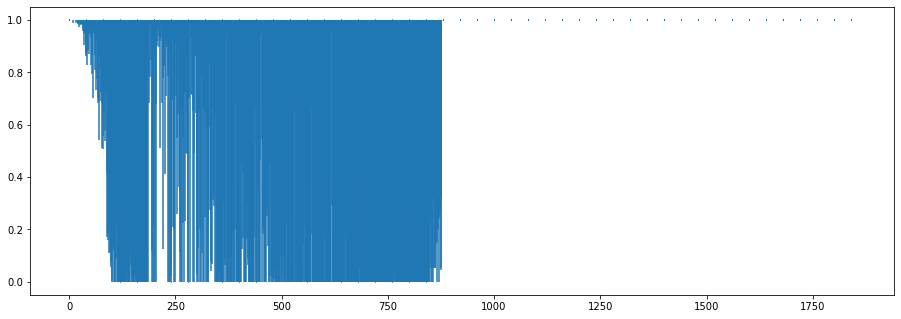

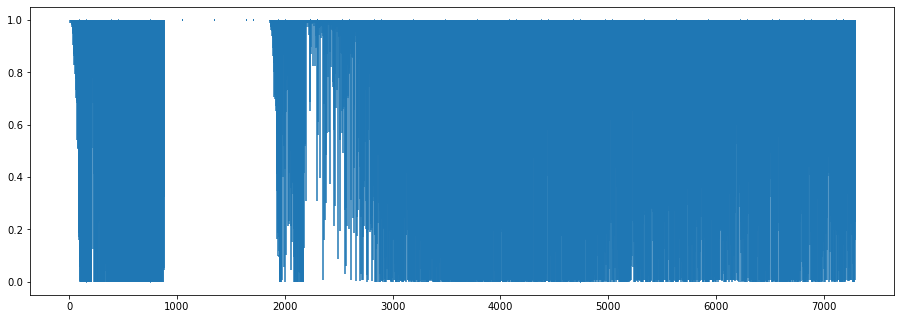

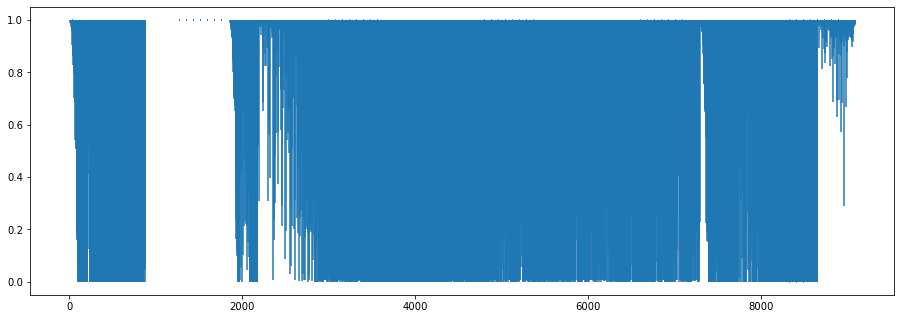

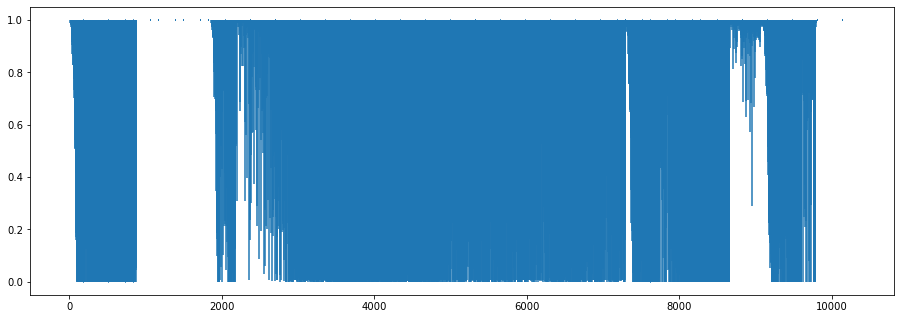

c:\users\abuaishe\appdata\local\programs\python\python38-32\lib\site-packages\matplotlib\cbook\__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
c:\users\abuaishe\appdata\local\programs\python\python38-32\lib\site-packages\numpy\core\fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


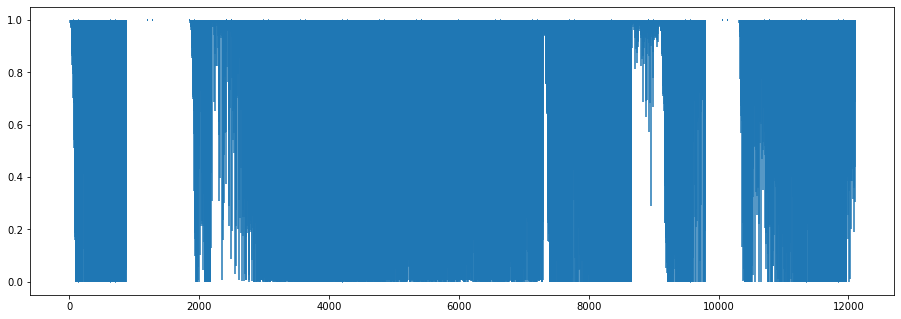

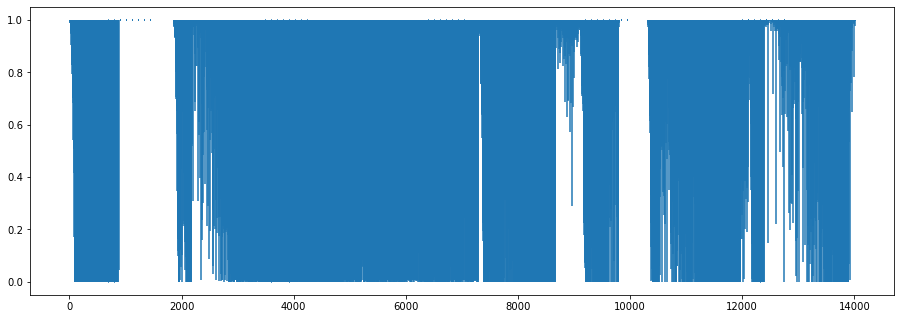

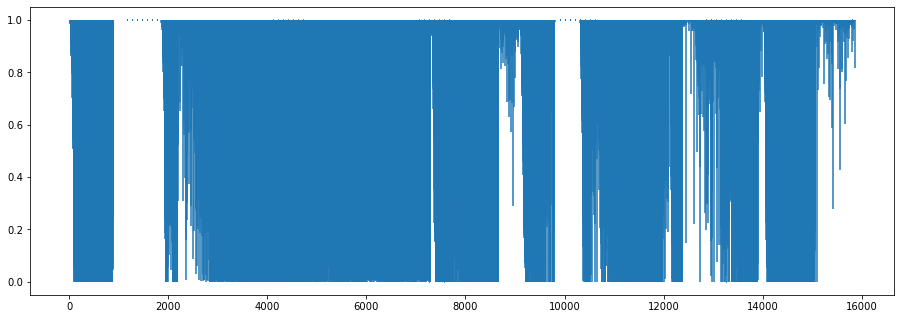

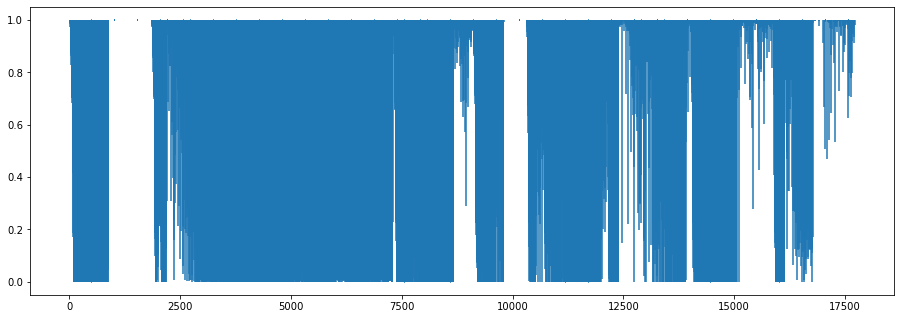

In [384]:
################################## Violin Plot #############################################

# want to create a panda dataframe for every simSetting
# e.g 10 robots, empty floorplan, upper pdr threshold 0.9, lower pdr threshold 0.7 ...etc
# every simSetting will have a unique identifier
# lets say we have 100 runs per setting and have 3 settings
# we will have 3 panda data frames, each with 100x (time-to-completion) lines
# for every data frame we will find the confidence interval.
# this data will be use all through out the notebook to create the plots.

#aggrigated data of 1 or more run will result in log file with 1-n run data files
# we want a plot per config
# for every config we will have 0-time2completion pdr_collections

data_to_plot = []

for config in config_ids:
    for run in globals()[f'{config}_data']:
        pdr_profiles = [profile for profile in run['pdrProfile'] if type(profile) is not float]

        for idx,profile in enumerate(pdr_profiles):
            pdr_collection = [pdr[2] for pdr in profile]

            data_to_plot.append(pdr_collection)

        # Create a figure instance
        fig = plt.figure()
        completion_time=list(run['time'])[-1]
        # Create an axes instance
        ax = fig.add_axes([0,0,2,1])
        # Create the boxplot
        bp = ax.violinplot(data_to_plot, vert=True, widths=0.1, showmeans=True, showextrema=True)
        plt.show()


In [ ]:
################################## Heatmap     #############################################


                                                   0
1                 type mapping profile  \
0    ti...
2                 type mapping profile  \
0    ti...


<ipython-input-389-b33ddc0f58a6>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mapping_profile = df[run['mappingProfile'].notnull()]


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (10, 4) + inhomogeneous part.

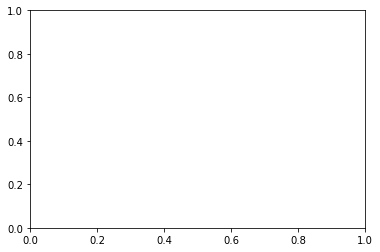

In [389]:
################################## Mapping Profile  ########################################

for config in config_ids:
    (fig,ax) = plt.subplots()
    profiles = []
    for run in globals()[f'{config}_data']:
        for mp in mapping_profile:
            if mp == np.nan or mp =="nan" or mp is float:
                print("woops")
        mapping_profile = [mp for mp in run['mappingProfile'] if mp]

